In [1]:
import numpy as np

In [2]:
from spline import Spline, get_spline

In [3]:
p = np.array([[1, 1], [13, 40], [56, 78], [32, 4]])

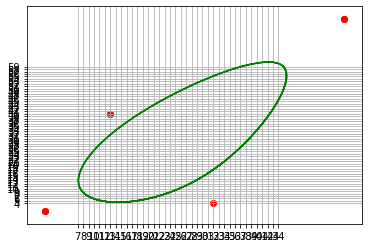

In [4]:
spline = Spline(p)
spline.drawCurve()

In [5]:
im_height, im_width = 256, 256

### Network

In [6]:
import tensorflow as tf

In [7]:
from tensorflow.keras.losses import BinaryCrossentropy

In [8]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import plot_model

In [9]:
def iou(y_true: tf.Tensor, y_pred: tf.Tensor) -> float:
    """Calculate intersection over union for the given batch."""
    # Cast both arrays to boolean arrays according to a cut-off of 0.5
    y_pred = (y_pred > 0.5)
    y_true = (y_true > 0.5)

    # Mark each pixel as True if both predicts True (TP)
    intersection_mask = tf.math.logical_and(y_pred, y_true)

    # Mark each pixel as True if either true positive, false negative, or false
    # positive (TP + FP + FN)
    union_mask = tf.math.logical_or(y_pred, y_true)

    # Calculate sum of true positives
    intersection = tf.math.count_nonzero(intersection_mask, axis=(1, 2))

    # Calculate sum of true positives fales negatives/positives
    union = tf.math.count_nonzero(union_mask, axis=(1, 2))

    # Set union to 1 where there are no true positives in order to prevent
    # division by zero
    dividing_union = tf.where(union == 0, tf.ones_like(union), union)

    # Calculate intersection over union
    ious = intersection / dividing_union

    # Set IoU to 1 where there are no true positives
    ious = tf.where(union == 0, tf.ones_like(ious), ious)

    # Return the mean IoU across the batch
    return tf.reduce_mean(ious)

In [10]:
def loss_fn(gt_img, p_pred):
    y_pred = get_spline(p_pred)
    return BinaryCrossentropy(gt_img, y_pred) 

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    """
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    """
    
    return x
  

def network(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):

    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    p5 = MaxPooling2D((2, 2))(c5)
    p5 = Dropout(dropout)(p5)
    
    #outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    
    f = Flatten()(p5)
    
    d = Dense(8, activation='relu')(f)
    
    outputs = d
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [12]:
def get_model():
    input_img = Input((im_height, im_width, 1), name='img')
    model = network(input_img, n_filters=16, dropout=0.05, batchnorm=True)
    model.compile(optimizer=Adam(), loss=loss_fn, metrics=["accuracy"])
    return model

In [13]:
model = get_model()

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640  

In [15]:
X = np.ones((1, 256, 256, 1), dtype='float32')

In [16]:
cp = model.predict(X)

In [17]:
cp = cp[0]

In [18]:
print(cp)
p = np.zeros((4, 2))
for i in range(4):
    p[i, 0] = cp[2*i]
    p[i, 1] = cp[2*i+1]

[0.         0.         0.68801844 0.         0.         0.
 0.         1.4101901 ]


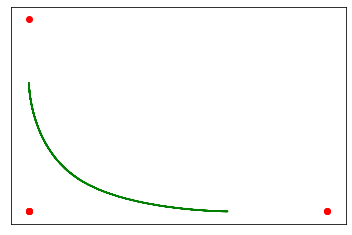

In [19]:
spline = Spline(p)
spline.drawCurve()

In [20]:
spline.p

array([[0.        , 0.        ],
       [0.68801844, 0.        ],
       [0.        , 0.        ],
       [0.        , 1.41019011],
       [0.        , 0.        ],
       [0.68801844, 0.        ],
       [0.        , 0.        ]])

In [21]:
spline.pixelate()


stepsize = 0.35890830300789395


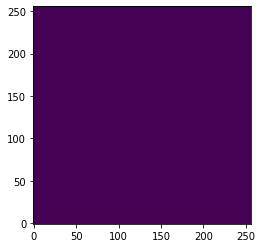

In [22]:
spline.drawImg()